# Import required python libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import PIL
import os
from PIL import Image
import pandas as pd

!pip install split-folders
import splitfolders

import random

# Data Load

In [2]:
# 과제 시 데이터셋 경로 설정
# For homework
!gdown "1D0mdy2g8gzhg4-pQWrun5lOlwBzB3lnG&confirm=t"
!mkdir dataset
!zip -d in_class.zip "__MACOSX*"
!zip -d in_class.zip "*/.DS*"
!unzip in_class.zip -d ./dataset

!gdown "1qAAZKnw3dRSOqxs2O-SYtuhGIUlOZJBE&confirm=t"
!zip -d homework.zip "__MACOSX*"
!zip -d homework.zip "*/.DS*"
!unzip homework.zip -d ./dataset

# Dataset 폴더에 20개 동물 이미지 생성

Downloading...
From: https://drive.google.com/uc?id=1D0mdy2g8gzhg4-pQWrun5lOlwBzB3lnG&confirm=t
To: /content/in_class.zip
100% 64.3M/64.3M [00:00<00:00, 124MB/s]
deleting: __MACOSX/._bear
deleting: __MACOSX/bear/._093836b753.jpg
deleting: __MACOSX/bear/._08e665796d.jpg
deleting: __MACOSX/bear/._0e6a8744de.jpg
deleting: __MACOSX/bear/._9a34b276e2.jpg
deleting: __MACOSX/bear/._6bee43b688.jpg
deleting: __MACOSX/bear/._5db7b4c807.jpg
deleting: __MACOSX/bear/._.DS_Store
deleting: __MACOSX/bear/._4ab1a3197a.jpg
deleting: __MACOSX/bear/._25e21b4f3e.jpg
deleting: __MACOSX/bear/._8ab6a06ff9.jpg
deleting: __MACOSX/bear/._36a8de3afb.jpg
deleting: __MACOSX/bear/._1971d6e226.jpg
deleting: __MACOSX/bear/._0f6b575750.jpg
deleting: __MACOSX/bear/._26f9a8f6e9.jpg
deleting: __MACOSX/bear/._5687a6bcec.jpg
deleting: __MACOSX/bear/._28cf1633e6.jpg
deleting: __MACOSX/bear/._87a4b68284.jpg
deleting: __MACOSX/bear/._8fccd0fedd.jpg
deleting: __MACOSX/bear/._385cd10acb.jpg
deleting: __MACOSX/bear/._1eda26b7f5.j

In [3]:
root_dir = "./dataset"

In [4]:
class_names = sorted(x for x in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, x)))  #  클래스 이름 리스트
num_class = len(class_names) # 클래스 개수
image_files = [ # 각 클래스별 이미지 경로 리스트
    [os.path.join(root_dir, class_names[i], x) for x in os.listdir(os.path.join(root_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)] # 각 클래스별 이미지 개수
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i]) # 이미지 경로 리스트
    image_class.extend([i] * num_each[i]) # 이미지 라벨 리스트
num_total = len(image_class)   # 전체 이미지 개수
image_width, image_height = PIL.Image.open(image_files_list[0]).size # 이미지 사이즈 확인

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 997
Image dimensions: 300 x 168
Label names: ['antelope', 'bear', 'bison', 'chimpanzee', 'cow', 'deer', 'dolphin', 'duck', 'fox', 'goat', 'goose', 'gorilla', 'ox', 'panda', 'reindeer', 'shark', 'sheep', 'swan', 'whale', 'wolf']
Label counts: [50, 49, 50, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 49, 50, 50, 50, 50]


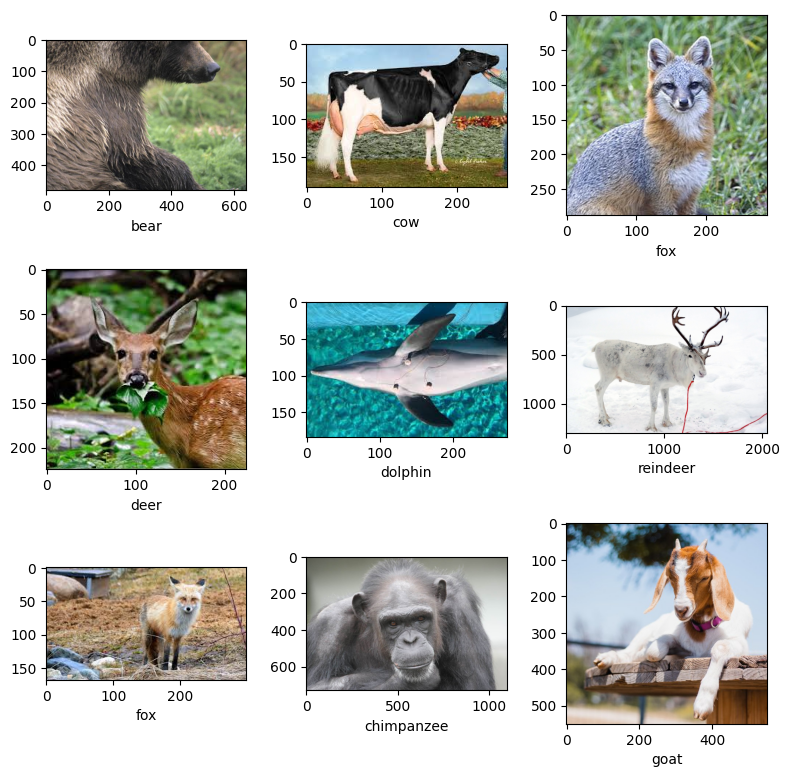

In [5]:
# 예시 이미지 출력
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [6]:
data_dir="data"
random.seed(1232)

# train, val, test 데이터로 분할
splitfolders.ratio(root_dir, data_dir,
                   ratio=(.6,.2,.2),group_prefix=None) # 각 클래스별 1000개씩 train, 100개씩 val, 100개씩 test 데이터로 분할

Copying files: 997 files [00:00, 1897.31 files/s]


In [7]:
print(os.listdir(os.path.join(data_dir,"train"))) # train 데이터 확인

['bison', 'duck', 'reindeer', 'gorilla', 'dolphin', 'ox', 'whale', 'cow', 'swan', 'goat', 'bear', 'fox', 'wolf', 'sheep', 'antelope', 'deer', 'panda', 'shark', 'goose', 'chimpanzee']


In [8]:
# Data augmentation and normalization for training
# Just normalization for validation

# 데이터셋에 적용할 변형(transformation) 정의
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 만들기
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
# 데이터로더 만들기
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=15,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']} # 데이터셋 크기
class_names = image_datasets['train'].classes # 클래스 이름

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용 가능 여부에 따라 device 정보 저장

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
dataset_sizes # 데이터셋 크기 확인

{'train': 597, 'val': 197, 'test': 203}

# Model Training

In [10]:
n_features = 20 # change class num

model = models.resnet101(pretrained=True)  # resnet50 모델 불러오기
model.fc = nn.Linear(model.fc.in_features, n_features)
model.to(device)

model;

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:06<00:00, 26.5MB/s]


In [11]:
loss_function = torch.nn.CrossEntropyLoss() # loss function 정의
optimizer = torch.optim.Adam(model.parameters(), 1e-5) # optimizer 정의
max_epochs = 30 # epoch 수 정의

In [12]:
best_acc = 0.0

Loss_dict = {"train":[],"val":[]}
Acc_dict = {"train":[],"val":[]}

for epoch in range(max_epochs): # epoch 반복
    print(f'Epoch {epoch+1}/{max_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_function(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            print(f"{phase} loss: {loss.item():.4f}")

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        Loss_dict[phase].append(epoch_loss)
        Acc_dict[phase].append(epoch_acc.item())

        # Loss
        plt.plot(range(len(Loss_dict[phase])),Loss_dict[phase])
        plt.savefig(f"{phase}_Loss.png")
        plt.close()
        # ACC
        plt.plot(range(len(Acc_dict[phase])),Acc_dict[phase])
        plt.savefig(f"{phase}_ACC.png")
        plt.close()

        print(f'{phase} Total Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_model_params.pt')

    print()

# best val accuracy 값 출력
print(f'Best val Acc: {best_acc:4f}')


Epoch 1/30
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train loss: 3.0143
train loss: 3.0863
train loss: 3.2456
train loss: 3.0294
train loss: 3.0096
train loss: 3.0456
train loss: 3.0693
train loss: 2.9285
train loss: 2.9600
train loss: 2.8803
train loss: 2.9803
train loss: 3.0386
train loss: 3.0235
train loss: 2.9698
train loss: 2.9433
train loss: 2.9548
train loss: 3.2816
train loss: 2.8006
train loss: 2.8513
train loss: 2.8023
train loss: 2.7903
train loss: 2.8112
train loss: 2.7434
train loss: 2.9163
train loss: 2.8643
train loss: 2.8139
train loss: 2.7846
train loss: 2.8103
train loss: 2.6835
train loss: 2.6691
train loss: 2.8957
train loss: 2.8780
train loss: 2.8801
train loss: 2.7494
train loss: 2.7327
train loss: 2.5095
train loss: 2.5865
train loss: 2.6080
train loss: 2.6367


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train loss: 2.5998
train Total Loss: 2.8733 Acc: 0.1558
val loss: 2.6691
val loss: 2.6467
val loss: 2.6259
val loss: 2.6592
val loss: 2.4285
val loss: 2.4963
val loss: 2.4458
val loss: 2.6109
val loss: 2.6114
val loss: 2.7079
val loss: 2.6273
val loss: 2.6430
val loss: 2.5297
val loss: 2.7079
val Total Loss: 2.5936 Acc: 0.3807

Epoch 2/30
----------
train loss: 2.4345
train loss: 2.4683
train loss: 2.4925
train loss: 2.3092
train loss: 2.4892
train loss: 2.4942
train loss: 2.4428
train loss: 2.3583
train loss: 2.3332
train loss: 2.5168
train loss: 2.3293
train loss: 2.6338
train loss: 2.5000
train loss: 2.4962
train loss: 2.2325
train loss: 2.2400
train loss: 2.5394
train loss: 2.4949
train loss: 2.5084
train loss: 2.4819
train loss: 2.2071
train loss: 2.3980
train loss: 2.1935
train loss: 2.2312
train loss: 2.1752
train loss: 2.4359
train loss: 2.6155
train loss: 2.1731
train loss: 2.3816
train loss: 2.2811
train loss: 2.1914
train loss: 2.2711
train loss: 2.2224
train loss: 2.1572
tr

# Model Evaluation

In [13]:
n_features = 20

model = models.resnet101(pretrained=True).to(device)  # resnet50 모델 불러오기
model.fc = nn.Linear(model.fc.in_features, n_features)
model = model.to(device)

# load best model weights
model.load_state_dict(torch.load('best_model_params.pt'))

<All keys matched successfully>

In [14]:
model.eval() # 모델 평가 모드로 전환
y_true = [] # 정답 라벨 리스트
y_pred = [] # 예측 라벨 리스트

In [15]:
# 모델 평가
with torch.no_grad(): # 평가시에는 gradient 계산을 수행하지 않음
    for i, (inputs, labels) in enumerate(dataloaders["test"]): # test 데이터에 대해 batch 단위로 반복
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs) # 모델 출력
        _, preds = torch.max(outputs, 1) # 모델 출력값 중 가장 큰 값의 인덱스 저장
        print(len(preds) ,end='\r')
        for i in range(len(preds)): # batch 단위로 예측값과 정답값 저장
          y_true.append(labels[i].item()) # 정답 라벨 리스트에 정답값 저장
          y_pred.append(preds[i].item()) # 예측 라벨 리스트에 예측값 저장

In [16]:
from sklearn.metrics import classification_report

# classification report 출력
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    antelope     0.9091    1.0000    0.9524        10
        bear     1.0000    0.9091    0.9524        11
       bison     0.8182    0.9000    0.8571        10
  chimpanzee     1.0000    1.0000    1.0000        11
         cow     0.6667    0.6000    0.6316        10
        deer     0.8889    0.8000    0.8421        10
     dolphin     0.9091    1.0000    0.9524        10
        duck     1.0000    0.9000    0.9474        10
         fox     1.0000    1.0000    1.0000        10
        goat     0.8889    0.8000    0.8421        10
       goose     0.8333    1.0000    0.9091        10
     gorilla     1.0000    1.0000    1.0000        10
          ox     0.7273    0.8000    0.7619        10
       panda     0.9091    1.0000    0.9524        10
    reindeer     0.9000    0.9000    0.9000        10
       shark     1.0000    0.9091    0.9524        11
       sheep     0.9000    0.9000    0.9000        10
        swan     1.0000    

# External Test

In [17]:
# External test - 학습후 아래 코드를 통해 생성된 파일을 제출해주세요!

# Test
!gdown "1LFdqV32j1GqBaKbAwGd0RyWTgnx-7n5m&confirm=t"
!mkdir ext_dataset
!zip -d external_test.zip "__MACOSX*"
!zip -d external_test.zip "*/.DS*"
!unzip external_test.zip -d ./ext_dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset = datasets.ImageFolder("ext_dataset",data_transforms["test"])
test_loader = torch.utils.data.DataLoader(test_dataset,
                            batch_size=30,shuffle=True, num_workers=4)
n_features = 20

model = models.resnet101(pretrained=True).to(device)  # resnet50 모델 불러오기
model.fc = nn.Linear(model.fc.in_features, n_features)
model = model.to(device)

# load best model weights
model.load_state_dict(torch.load('best_model_params.pt'))
y_pred = []
for i, (inputs, _) in enumerate(test_loader): # test 데이터에 대해 batch 단위로 반복
    inputs = inputs.to(device)

    outputs = model(inputs) # 모델 출력
    _, preds = torch.max(outputs, 1) # 모델 출력값 중 가장 큰 값의 인덱스 저장

    y_pred.extend([d.item() for d in preds])

imgs = []
plabels = []

# 과제 제출용 코드
for (img,_),p in zip(test_dataset.imgs,y_pred):
  plabels.append(class_names[p])
  imgs.append(os.path.basename(img))

pd.DataFrame({"Image":imgs,"Label":plabels}).to_csv("Assignment2_prediction_2070044_오예인.csv")

Downloading...
From: https://drive.google.com/uc?id=1LFdqV32j1GqBaKbAwGd0RyWTgnx-7n5m&confirm=t
To: /content/external_test.zip
100% 31.8M/31.8M [00:00<00:00, 115MB/s]
deleting: __MACOSX/._external_test
deleting: __MACOSX/external_test/._50eff9bc37.jpg
deleting: __MACOSX/external_test/._36ba2541c2.jpg
deleting: __MACOSX/external_test/._2ac90b7372.jpg
deleting: __MACOSX/external_test/._1b890605d5.jpg
deleting: __MACOSX/external_test/._3acb463808.jpg
deleting: __MACOSX/external_test/._70e093d09f.jpg
deleting: __MACOSX/external_test/._28dba6a409.jpg
deleting: __MACOSX/external_test/._8fd20d83cc.jpg
deleting: __MACOSX/external_test/._2aae9ae91c.jpg
deleting: __MACOSX/external_test/._098c4da6d0.jpg
deleting: __MACOSX/external_test/._2b60bdb95d.jpg
deleting: __MACOSX/external_test/._6b0dc9ab1a.jpg
deleting: __MACOSX/external_test/._227a1315f3.jpg
deleting: __MACOSX/external_test/._45983750c0.jpg
deleting: __MACOSX/external_test/._4ffa9f872e.jpg
deleting: __MACOSX/external_test/._9cdcad3179.jp

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can al